# Tracing

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 10] 

In [3]:
def parse_trace(di, fix = 0):
    trace = pd.DataFrame(columns=["event", "id", "ts", "location"])
    for dirpath, dnames, fnames in os.walk(di):
        for f in fnames:
            if f.endswith(".csv"):
                t = pd.read_csv(os.path.join(dirpath, f), header=None, names=['event', 'id', 'ts'])
                t['location'] =  os.path.splitext(f)[0]
                trace = pd.concat([trace, t])
    trace = trace.set_index("id")
    return trace.apply(pd.to_numeric, errors='ignore')

In [4]:
def delay_between(trace, from_event, to_event, from_location = None, to_location = None):
    data = trace[(trace['event'] == from_event) | (trace['event'] == to_event)]
    joined = trace.join(trace, lsuffix='_from', rsuffix='_to', how='inner')
    filtered = joined[(joined['event_from'] == from_event) & (joined['event_to'] == to_event)]
    if from_location is not None:
        filtered = filtered[filtered['location_from'] == from_location]
    if to_location is not None:
        filtered = filtered[filtered['location_to'] == to_location]
    result = np.array((filtered['ts_to'] - filtered['ts_from']).unique(), dtype=np.int64)
    if len(result) < 500:
        print("There are " + str(len(result)) + " events from: '" + from_event + "', to: '" + to_event + ";")
    return result

In [86]:
def sync_skew(trace, from_event, to_event):
    for location in trace['location'].unique():
        d = delay_between(trace, from_event, to_event, from_location=location)
        if d.size > 0:
            min = d.min()
            trace.loc[trace['location'] == location, 'ts'] += min
    return trace

In [87]:
def read_data(filename):
    with open(filename) as f:
        d = np.array(f.read().strip().split(','), dtype=np.int64)
        return d[200:] / 1e6

# Latencies

In [102]:
flink = read_data("data/90f8c4f0/10/70/flink/latency/lat.data")

flamestream = read_data("data/90f8c4f0/10/70/flamestream/latency/lat.data")

no_barrier = read_data('../FlameStream/benchmark/ansible/results/ea8614e6/10/70/flamestream/latency/lat.data')
no_barrier = no_barrier[no_barrier > 0]

buffer = read_data('../FlameStream/benchmark/ansible/results/faf2bfad/10/70/flamestream/latency/lat.data')
buffer = buffer[buffer > 0]

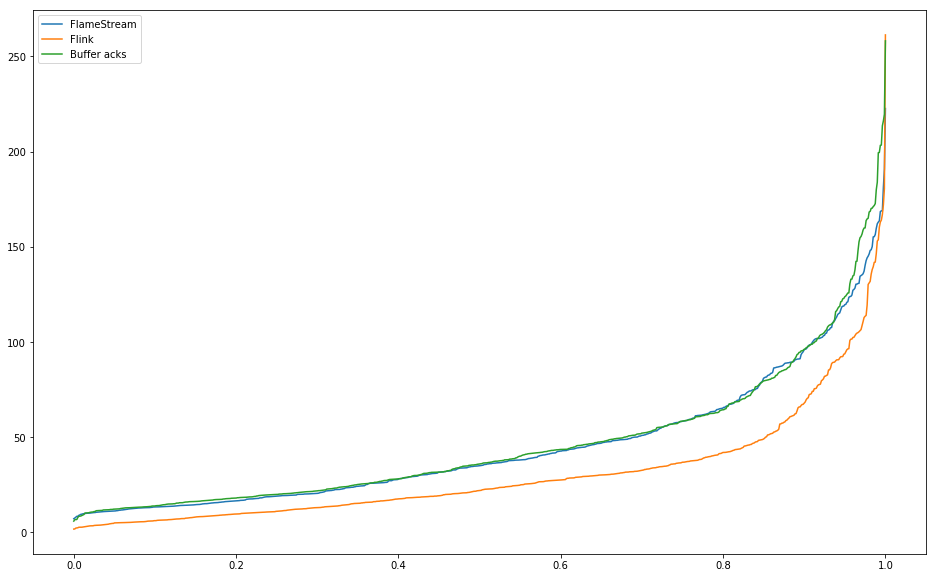

In [103]:
plt.plot(np.linspace(0, 1, len(flamestream)), np.sort(flamestream, axis=0), label='FlameStream')
plt.plot(np.linspace(0, 1, len(flink)), np.sort(flink, axis=0), label='Flink')
# plt.plot(np.linspace(0, 1, len(no_barrier)), np.sort(no_barrier, axis=0), label='No barrier')
plt.plot(np.linspace(0, 1, len(buffer)), np.sort(buffer, axis=0), label='Buffer acks')
plt.legend(loc = 'upper left')

# Tracing

In [90]:
def plot_fs_trace(trace):
    plt.xlim((0.8, 1))
    plt.ylim((0, 120))
    plt.xlabel("Quantile")
    plt.ylabel("Latency (ms)")

    bench_front = delay_between(trace, 'bench-send', 'front-receive-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), "r", label="bench - front (network)")

    to_source = delay_between(trace, 'front-receive-send', 'flatmap-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(to_source)), np.sort(to_source), "g", label="front - flatmap (shuffle)")

    #plt.plot(np.linspace(0, 1, np.size(b)), np.sort(b), "r", label="Barrier delay")

    part = delay_between(trace, 'flatmap-send', 'grouping-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(part)), np.sort(part), "b", label="flatmap - grouping (shuffle)")

    accept = delay_between(trace, 'accept-in', 'accept-out') / 1e6
    plt.plot(np.linspace(0, 1, np.size(accept)), np.sort(accept), label="accept (chaincall)")

    inject = delay_between(trace, 'inject-in', 'inject-out') / 1e6
    plt.plot(np.linspace(0, 1, np.size(inject)), np.sort(inject), label="inject (chaincall)")

    to_rear = delay_between(trace, 'barrier-send', 'rear-in') / 1e6
    plt.plot(np.linspace(0, 1, np.size(to_rear)), np.sort(to_rear), label="barrier - rear (queue)")

    rear_bench = delay_between(trace, 'rear-in', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(rear_bench)), np.sort(rear_bench), "m", label="rear - bench (network)")

    front_source = delay_between(trace, 'front-receive-send', 'accept-in') / 1e6
    plt.plot(np.linspace(0, 1, np.size(front_source)), np.sort(front_source), label="front - source (local queue)")

    plt.legend(loc='upper left')

In [91]:
def plot_fl_trace(trace):
    plt.xlim((0.8, 1))
    plt.ylim((0, 120))
    plt.xlabel("Quantile")
    plt.ylabel("Latency (ms)")

    bench_front = delay_between(flink_trace, 'bench-send', 'source-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), "r", label="bench - front (network)")

    source_fm = delay_between(flink_trace, 'source-receive', 'flatmap-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(source_fm)), np.sort(source_fm), "g", label="front - flatmap (shuffle)")

    fm_enforcer = delay_between(flink_trace, 'flatmap-send', 'enforcer-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(fm_enforcer)), np.sort(fm_enforcer), "b", label="flatmap - enforcer (shuffle)")

    a = delay_between(flink_trace, 'enforcer-receive', 'enforcer-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(a)), np.sort(a), "y", label="order enforcer")

    enforcer_sink = delay_between(flink_trace, 'enforcer-send', 'sink-receive') / 1e6
    #plt.plot(np.linspace(0, 1, np.size(enforcer_sink)), np.sort(enforcer_sink), label="enforcer - sink")

    sink_bench = delay_between(flink_trace, 'sink-receive', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(sink_bench)), np.sort(sink_bench), "m", label="sink - bench (network)")

    plt.legend(loc='upper left')


In [99]:
trace = sync_skew(parse_trace("../FlameStream/benchmark/ansible/results/4e3376ac/10/70/flamestream/traces"), 'rear-in', 'bench-receive')
start = trace['ts'].min() + 200 * (100 * 1e6)
trace = trace[trace['ts'] > start]
trace.shape

There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;


(71003, 3)

In [95]:
flink_trace = sync_skew(parse_trace("../FlameStream/benchmark/ansible/results/c09cbafb/10/70/flink/traces"), 'sink-receive', 'bench-receive')
start = flink_trace['ts'].min() + 200 * (100 * 1e6)
flink_trace = flink_trace[flink_trace['ts'] > start]
flink_trace.shape

There are 0 events from: 'sink-receive', to: 'bench-receive;


(38472, 3)

In [96]:
barrier_lat = parse_trace("../FlameStream/benchmark/ansible/results/c09cbafb/10/70/flamestream/traces")
b = barrier_lat[barrier_lat['event'] == 'barrier-delay']['ts'] / 1e6

There are 0 events from: 'barrier-send', to: 'rear-in;


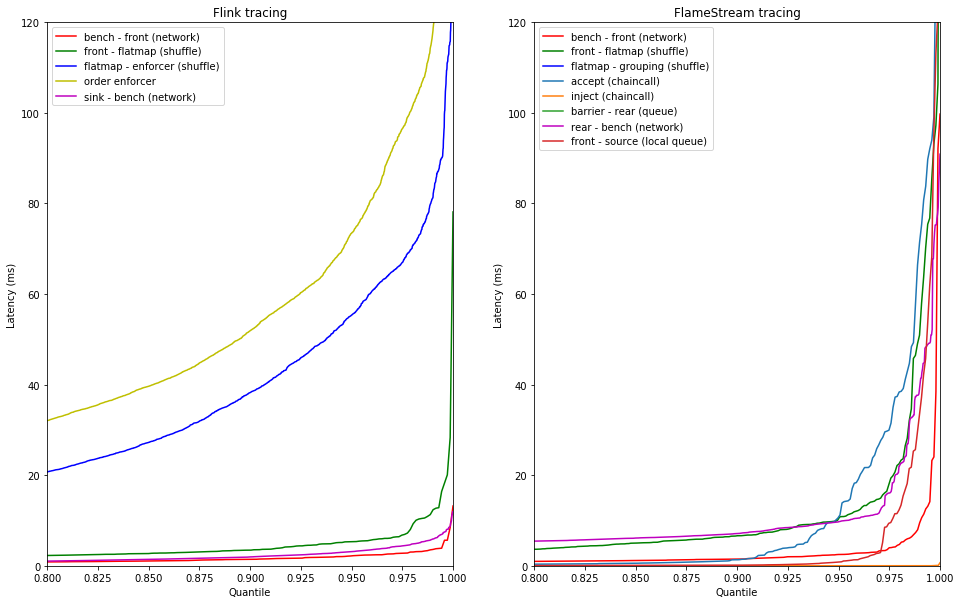

In [97]:
plt.subplot(1, 2, 1)
plt.title("Flink tracing")
plot_fl_trace(flink_trace)

plt.subplot(1, 2, 2)
plt.title("FlameStream tracing")
plot_fs_trace(trace)

plt.show()

# Regression

In [144]:
no_ack = sync_skew(parse_trace("../FlameStream/benchmark/ansible/results/6261e62c/4/70/flamestream/traces"), 'rear-in', 'bench-receive')
start = no_ack['ts'].min() + 200 * (100 * 1e6)
no_ack = no_ack[no_ack['ts'] > start]
no_ack.shape

There are 0 events from: 'rear-in', to: 'bench-receive;


(56940, 3)

In [145]:
ack = sync_skew(parse_trace("../FlameStream/benchmark/ansible/results/6131f86e/5/150/flamestream/traces"), 'rear-in', 'bench-receive')
start = ack['ts'].min() + 200 * (100 * 1e6)
ack = ack[ack['ts'] > start]
ack.shape

There are 0 events from: 'rear-in', to: 'bench-receive;


(71197, 3)

There are 0 events from: 'barrier-receive', to: 'barrier-send;
There are 0 events from: 'barrier-send', to: 'rear-in;
There are 0 events from: 'barrier-receive', to: 'barrier-send;
There are 0 events from: 'barrier-send', to: 'rear-in;


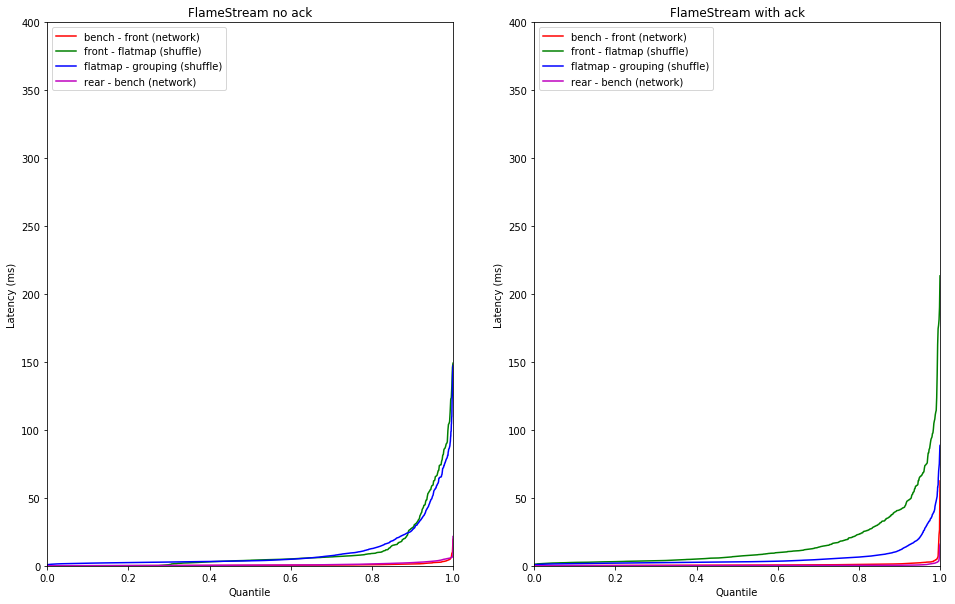

In [147]:
plt.subplot(1, 2, 1)
plt.title("FlameStream no ack")
plot_fs_trace(no_ack)

plt.subplot(1, 2, 2)
plt.title("FlameStream with ack")
plot_fs_trace(ack)

plt.show()